# Imports, Variables & Function definitions

In [2]:



#Imports
import tensorflow as tf
from keras.datasets import mnist
import foolbox as fb
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from sklearn.neighbors import NearestNeighbors
from itertools import product
from scipy.ndimage.interpolation import rotate, shift
import csv



#Variables
epsilon=0.3
batch_size=1024
epochs=1000
pgd_steps=50
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Foolbox version: ", fb.__version__)
print(tf.config.list_physical_devices('GPU'))
np.random.seed(10)


#get MNIST data and prepare
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

#define variables needed for attacks
x_attack_to_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_attack_to_train=x_attack_to_train[:,:,:,np.newaxis]
y_attack_to_train=tf.convert_to_tensor(y_train, dtype=tf.int32)

x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)

attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)

#for generating invariance-based adversarial examples
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()




#Functions
def test_model(model):
    
    assert epsilon==0.3
    inv_advs_to_test=np.load("data/invariance_examples_tramer/linf/automated_eps03.npy")[0:100]
    inv_labels_to_test=np.load("data/invariance_examples_tramer/linf/automated_eps03_labels.npy")[0:100]
    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))      
    

    # x_batch,y_batch=next_batch(100,x_test,y_test)
    x_batch,y_batch=x_test[0:100],y_test[0:100]
    x_batch_to_test = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    y_batch_to_test=tf.convert_to_tensor(y_batch, dtype=tf.int32)

    _,advs_to_test, success=attack(fmodel,x_batch_to_test, y_batch_to_test, epsilons=epsilon)
   
    
    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    x=tf.keras.backend.get_value(advs_to_test)
    ptb_test=x

    #get accuracies and losses
    acc =model.evaluate(x_test[0:100],to_categorical(y_test[0:100]), verbose=0)
    acc_ptb = model.evaluate(ptb_test,to_categorical(y_batch), verbose=0)
    acc_inv = model.evaluate(inv_advs_to_test,to_categorical(inv_labels_to_test), verbose=0)


    # get invariance adversarial examples success rate
    predictions=model.predict(inv_advs_to_test)
    disagreeing=0
    for i in range(len(predictions)):
        if inv_labels_to_test[i] !=np.argmax(predictions[i]):
            disagreeing+=1
    # plt.imshow(ptb_test[0], cmap='gray')
    # plt.show()  
   
      
    return {
    "clean":{"loss": acc[0], "accuracy":acc[1]},
    "ptb":{"loss": acc_ptb[0], "accuracy":acc_ptb[1]},
    "inv":{"loss": acc_inv[0], "accuracy":acc_inv[1]},
    "inv_success_rate":disagreeing/100}


def create_vanilla_model():
      print("creating vanilla model...")
      
      val_images = x_train[:10000]
      partial_images = x_train[10000:]
      val_labels = y_train[:10000]
      partial_labels = y_train[10000:]

      model = Sequential()

      model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Flatten())
      model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(10, activation='softmax'))
     


      earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 1, 
                                        restore_best_weights = True)

      model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
      print("training vanilla model...")
      history=model.fit(partial_images,to_categorical(partial_labels),
                  validation_data =(val_images, to_categorical(val_labels)),
                  batch_size=batch_size,
                  epochs=epochs,
                  shuffle=True,
                  verbose=2,
                  callbacks =[earlystopping]
                  )
      print(np.shape(x_test))
      acc = model.evaluate(x_test[0:100],to_categorical(y_test[0:100]))
      print('BEFORE RETRAIN: Accuracy on clean testing data', acc[1])

      return model

def create_vanilla_model_tramer(filters=64, s1=5, s2=5, s3=3,
               d1=0, d2=0, fc=256,
               lr=1e-3, decay=1e-3):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size=(s1, s1),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters*2, (s2, s2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters*2, (s3, s3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(d1))
    model.add(Flatten())
    model.add(Dense(fc, activation='relu'))
    model.add(Dropout(d2))
    model.add(Dense(10))
    
   

    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    final = Sequential()
    final.add(model)
    final.add(Activation('softmax'))
    final.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        
    final.fit(x_train, to_categorical(y_train, 10),
              batch_size=256,
              epochs=20,
              shuffle=True,
              verbose=2,
    )
    return final    


# https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data
# Get random batch of data
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


# https://github.com/ftramer/Excessive-Invariance
def linf_attack(x, nn_adv, eps):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv


# https://github.com/ftramer/Excessive-Invariance
# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y, all_NNs, grid):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn


# https://github.com/ftramer/Excessive-Invariance
def generate_inv_adv_examples(epsilon_to_use, count):
    import numpy as np
    assert epsilon_to_use==0.3 or epsilon_to_use==0.4
    
    idxs=np.arange(0,count,1,dtype=int)

    #  Load the MNIST data. 300 randomly chosen test point
    assert len(idxs) == count
    test_xs = X_test[idxs]
    test_ys = Y_test[idxs]

    # build a nearest neighbors classifier per class
    N = 1
    all_NNs = []

    for i in range(10):
        #Reshape to 1D (28*28=784)
        X = X_train[Y_train == i].reshape(-1, 784)
        nn = NearestNeighbors(n_neighbors=N)
    
        nn.fit(X)
        all_NNs.append(nn)
    # print(all_NNs)



    # Rotation-translation parameters
    limits = [3, 3, 30]
    granularity = [5, 5, 31]
    grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))



    all_nns = []
    all_y_nns = []
    all_grids_nns = []

    # find nearest neighbors for some test inputs (this takes a little while)
    for i in range(len(idxs)):
        if i % 10 == 0:
            print("{}/{} done".format(i, len(idxs)))
        x = test_xs[i]
        y = test_ys[i]

        # find the nearest neighbors for each class, with the corresponding rotation and translation
        nns, y_nns, grids_nns = get_best_neighbors(x, y, all_NNs, grid)
        nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
        all_nns.append(nn_advs)
        all_y_nns.append(y_nns)
        all_grids_nns.append(np.asarray(grids_nns))



    # save everything!
    np.save("data/invariance_examples_generation/X_test_{}.npy".format(count), test_xs)
    np.save("data/invariance_examples_generation/all_nns.npy", np.asarray(all_nns))
    np.save("data/invariance_examples_generation/all_y_nns.npy", np.asarray(all_y_nns))
    np.save("data/invariance_examples_generation/all_grids_nns.npy", np.asarray(all_grids_nns))



    # (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    all_nns=np.load("data/invariance_examples_generation/all_nns.npy")
    all_y_nns=np.load("data/invariance_examples_generation/all_y_nns.npy")
    all_grids_nns=np.load("data/invariance_examples_generation/all_grids_nns.npy")
    test_xs=np.load("data/invariance_examples_generation/X_test_{}.npy".format(count))
  
    test_ys = y_test[idxs]

    # manually chosen target classes for each source class
    targets = {
        0: [4, 6, 8, 9],
        1: [4, 6, 7, 9],
        2: [8],
        3: [8],
        4: [8, 9],
        5: [3, 8],
        6: [0],
        7: [2, 3],
        8: [3],
        9: [3, 4, 5]
    }

    best_y_advs = []
    best_targets = []
    best_advs = []

    for i in range(len(all_nns)):
        x = test_xs[i]
        y = test_ys[i]
    
        best_x_adv = None
        best_nn_adv = None
        amount_removed = []
        amount_added = []
        rot = []
        best_y = None
        min_removed = np.inf
        for j in range(len(all_nns[i])):
            nn_adv = all_nns[i][j]
            y_nn = all_y_nns[i][j]
            # print("NN ADV: {}".format(np.shape(nn_adv)))
            # print("X: {}".format(np.shape(x)))
            x_adv = linf_attack(x, nn_adv, epsilon_to_use)
        
            
            # retain the target that required the least amount of pixels to be "removed"
            curr_rot = np.abs(all_grids_nns[i][j][-1])
            curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
            
            if y_nn in targets[y] and curr_removed < min_removed:
                min_removed = curr_removed
                best_y = y_nn
                best_x_adv = x_adv
                best_nn_adv = (nn_adv, y_nn)
                    
        best_targets.append(best_nn_adv)
        best_advs.append(best_x_adv)
        best_y_advs.append(best_y)
        

    
    # if epsilon_to_use==0.3:
    #     np.save("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples", best_advs)
    #     np.save("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_new_labels", best_y_advs)
    # else:
    #     np.save("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples", best_advs)
    #     np.save("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples_new_labels", best_y_advs)
    
def ptb_training(ptb_acc_to_achieve, model_to_train, include_inv_training=False, use_iterations=False, iterations=10):

    inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples.npy")
    inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_human_labels.npy")
    
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 1, 
                                       restore_best_weights = True)
    #While ACCURACY
    ptb_acc=0
    i=0
    y_axis=[]
    x_axis_ptb=[]
    x_axis_clean=[]
    x_axis_inv=[]
    if use_iterations==False:    
        while ptb_acc<=ptb_acc_to_achieve:
            res=test_model(model_to_train)
            ptb_acc=res.get("ptb").get("accuracy")
            clean_acc=res.get("clean").get("accuracy")
            inv_acc=res.get("inv").get("accuracy")

            i+=1
            y_axis.append(i)
            x_axis_ptb.append(ptb_acc)
            x_axis_clean.append(clean_acc)
            x_axis_inv.append(inv_acc)
            fmodel=fb.models.tensorflow.TensorFlowModel(model_to_train, bounds=(0,1))   
            x_batch,y_batch=next_batch(100,x_train,y_train)
            
            x_batch_to_train = tf.convert_to_tensor(x_batch, dtype=tf.float32)
            y_batch_to_train=tf.convert_to_tensor(y_batch, dtype=tf.int32)

            #attack model    
            _,advs, success=attack(fmodel, x_batch_to_train, y_batch_to_train, epsilons=epsilon) 
            success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
            
            #Retrain model with generated perturbation-based adversarial examples
            #80% Training 20% Validation
            x=tf.keras.backend.get_value(advs)
            # print("Shape of x_training before reshape: {}".format(np.shape(x)))
            # print("Shape of x_training after reshape: {}".format(np.shape(x)))
            x_training=x[0:int(len(x)*0.8)]
            x_validation=x[int(len(x)*0.8):int(len(x))]
            y_training=y_batch[0:int(len(x)*0.8)]
            y_validation=y_batch[int(len(x)*0.8):int(len(x))]
            
            model_to_train.fit(x_training,to_categorical(y_training,num_classes=10),
                validation_data =(x_validation,to_categorical(y_validation, num_classes=10)),
                epochs=epochs,
                verbose=0,
                callbacks =[earlystopping]
            )


            if include_inv_training==True:
                model_to_train.fit(inv_advs_to_train,to_categorical(inv_labels_to_train,num_classes=10),
                    epochs=10,
                    verbose=0
                )
        

            print("i: {} ptb acc: {}, inv_acc: {}".format(i,ptb_acc, inv_acc))
    else:
        while i<iterations:
            res=test_model(model_to_train)
            ptb_acc=res.get("ptb").get("accuracy")
            clean_acc=res.get("clean").get("accuracy")
            inv_acc=res.get("inv").get("accuracy")

            i+=1
            y_axis.append(i)
            x_axis_ptb.append(ptb_acc)
            x_axis_clean.append(clean_acc)
            x_axis_inv.append(inv_acc)
            fmodel=fb.models.tensorflow.TensorFlowModel(model_to_train, bounds=(0,1))   
            x_batch,y_batch=next_batch(100,x_train,y_train)
            
            x_batch_to_train = tf.convert_to_tensor(x_batch, dtype=tf.float32)
            y_batch_to_train=tf.convert_to_tensor(y_batch, dtype=tf.int32)

            #attack model    
            _,advs, success=attack(fmodel, x_batch_to_train, y_batch_to_train, epsilons=epsilon) 
            success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
            
            #Retrain model with generated perturbation-based adversarial examples
            #80% Training 20% Validation
            x=tf.keras.backend.get_value(advs)
            # print("Shape of x_training before reshape: {}".format(np.shape(x)))
            # print("Shape of x_training after reshape: {}".format(np.shape(x)))
            x_training=x[0:int(len(x)*0.8)]
            x_validation=x[int(len(x)*0.8):int(len(x))]
            y_training=y_batch[0:int(len(x)*0.8)]
            y_validation=y_batch[int(len(x)*0.8):int(len(x))]
            
            model_to_train.fit(x_training,to_categorical(y_training,num_classes=10),
                validation_data =(x_validation,to_categorical(y_validation, num_classes=10)),
                epochs=epochs,
                verbose=0,
                callbacks =[earlystopping]
            )


            if include_inv_training==True:
                model_to_train.fit(inv_advs_to_train,to_categorical(inv_labels_to_train,num_classes=10),
                    epochs=10,
                    verbose=0
                )
        

            print("i: {} ptb acc: {}, inv_acc: {}".format(i,ptb_acc, inv_acc))
    plt.plot( y_axis, x_axis_inv, label = "INV")
    plt.plot( y_axis, x_axis_clean, label = "Clean")
    plt.plot( y_axis, x_axis_ptb,label = "PTB")
    plt.xlabel('Iterationen')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return {
        "model": model_to_train,
        "clean":{ "accuracy": x_axis_clean},
        "ptb":{"accuracy":x_axis_ptb},
        "inv":{"accuracy":x_axis_inv},
        

    }

Tensorflow version:  2.8.0
Numpy version:  1.22.2
Foolbox version:  3.3.1
[]


# Create/train vanilla model

In [ ]:
create_vanilla_model().save("models/vanilla_model")

# Attack Vanilla Model and Retrain with Perturbation-Based Adversarial Examples iteratively
Result is ptb_trained_model

Takes a few minutes

In [ ]:
#get Model
model=load_model("models/vanilla_model")

ptb_acc_to_achieve=0.88
model,ptb_acc=ptb_training(ptb_acc_to_achieve, model)
model.save("models/ptb_trained_model_{}_ptb_accuracy".format(ptb_acc)) 

# Plot PTB Adversarial Training graphs

In [ ]:
def filter_array(array):
    filtered=[]
    for i in range(len(array)):
        if i%10==0:
            filtered.append(array[i])
    return filtered



y=np.load("data/ptb_training/iteration_count_arr.npy")
clean_arr=np.load("data/ptb_training/clean_accuracy_arr.npy")
ptb_arr=np.load("data/ptb_training/ptb_accuracy_arr.npy")
plt.plot( y, clean_arr, label = "Clean")
plt.plot( y, ptb_arr,label = "PTB")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

new_arr_x_ptb=filter_array(ptb_arr)
new_arr_x_clean=filter_array(clean_arr)
new_arr_y=filter_array(y)


plt.plot( new_arr_y, new_arr_x_clean, label = "Clean")
plt.plot( new_arr_y, new_arr_x_ptb,label = "PTB")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Max accuracy against PTB: {}".format(np.max(ptb_arr)))



# Generate INV-Based ADV-Examples 
Code is from https://github.com/ftramer/Excessive-Invariance

In [ ]:

# generate_inv_adv_examples(0.3,500)
# generate_inv_adv_examples(0.4,500)


# Plot INV-Based ADV-Examples

In [ ]:
inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_new_labels.npy")

print("----------EPSILON=0.3----------")
fig, axes = plt.subplots(50,10, figsize=(1.5*10,2*50))
for i in range(500):
    ax = axes[i//10,i%10]
    ax.imshow(inv_advs_to_train[i], cmap='gray')
    # ax.set_title('Label: {}'.format(inv_labels_to_train[i]))
    ax.set_title('Count: {}'.format(i))
plt.tight_layout()
plt.show()

inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples_new_labels.npy")


print()
print()
print("----------EPSILON=0.4----------")
fig, axes = plt.subplots(50,10, figsize=(1.5*10,2*50))
for i in range(500):
    ax = axes[i//10,i%10]
    ax.imshow(inv_advs_to_train[i], cmap='gray')
    # ax.set_title('Label: {}'.format(inv_labels_to_train[i]))
    ax.set_title('Count: {}'.format(i))
plt.tight_layout()
plt.show()

# Erster Durchlauf (Anzahl an Invariance-Based Adversarial Examples beim Trainieren variiert. Immer die neuen Labels verändern)

In [ ]:
# epsilon
epsilon=0.3

# c

c=[]
i=500
j=5
while j<=i:
    c.append(j)
    j+=5

vanilla_model=load_model("models/vanilla_model")

# m=l_infinity_PGD
# a=88.9
ptb_trained_model=load_model("models/ptb_trained_model_0.889_ptb_accuracy_PGD")

# Invariance-Based Adversarial Examples to train, use ONLY THE NEW LABELS
inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_new_labels.npy")



# Initialize writing results to csv
handler_inv_trained = open('data/results/erster_durchlauf/inv_trained.csv', 'w',encoding='UTF8',newline='')
writer_inv_trained = csv.writer(handler_inv_trained)
writer_inv_trained.writerow(["c","clean_acc","ptb_acc", "inv_acc", "clean_loss", "ptb_loss", "inv_loss", "inv_success_rate" ])


handler_ptb_inv_trained = open('data/results/erster_durchlauf/ptb_inv_trained.csv', 'w',encoding='UTF8',newline='')
writer_ptb_inv_trained = csv.writer(handler_ptb_inv_trained)
writer_ptb_inv_trained.writerow(["c","clean_acc","ptb_acc", "inv_acc", "clean_loss", "ptb_loss", "inv_loss", "inv_success_rate" ])



initial_results_vanilla=test_model(vanilla_model)
initial_results_ptb=test_model(ptb_trained_model)

data=[0,initial_results_vanilla.get("clean").get("accuracy"),
    initial_results_vanilla.get("ptb").get("accuracy"),
    initial_results_vanilla.get("inv").get("accuracy"),
    initial_results_vanilla.get("clean").get("loss"),
    initial_results_vanilla.get("ptb").get("loss"),
    initial_results_vanilla.get("inv").get("loss"),
    initial_results_vanilla.get("inv_success_rate"),
    ]

writer_inv_trained.writerow(data)

data=[0,initial_results_ptb.get("clean").get("accuracy"),
    initial_results_ptb.get("ptb").get("accuracy"),
    initial_results_ptb.get("inv").get("accuracy"),
    initial_results_ptb.get("clean").get("loss"),
    initial_results_ptb.get("ptb").get("loss"),
    initial_results_ptb.get("inv").get("loss"),
    initial_results_ptb.get("inv_success_rate"),
    ]

writer_ptb_inv_trained.writerow(data)


print("Initial results from Vanilla Model: {}".format(initial_results_vanilla))
print("Initial results from PTB-Trained Model: {}".format(initial_results_ptb))


results_inv_trained=[]
results_ptb_inv_trained=[]
for i in range(len(c)):
    print("Training with {} examples...".format(c[i]))

    vanilla_model.fit(inv_advs_to_train[0:c[i]],to_categorical(inv_labels_to_train[0:c[i]],num_classes=10),
    epochs=10,
    verbose=0)
    

    res=test_model(vanilla_model)
    results_inv_trained.append(res)
    data=[c[i],res.get("clean").get("accuracy"),
    res.get("ptb").get("accuracy"),
    res.get("inv").get("accuracy"),
    res.get("clean").get("loss"),
    res.get("ptb").get("loss"),
    res.get("inv").get("loss"),
    res.get("inv_success_rate"),
    ]
    # write to csv file
    writer_inv_trained.writerow(data)






    ptb_trained_model.fit(inv_advs_to_train[0:c[i]],to_categorical(inv_labels_to_train[0:c[i]],num_classes=10),
    epochs=10,
    verbose=0)

    res=test_model(ptb_trained_model)
    results_ptb_inv_trained.append(res)
    data=[c[i],res.get("clean").get("accuracy"),
    res.get("ptb").get("accuracy"),
    res.get("inv").get("accuracy"),
    res.get("clean").get("loss"),
    res.get("ptb").get("loss"),
    res.get("inv").get("loss"),
    res.get("inv_success_rate"),
    ]

    #write to csv file
    writer_ptb_inv_trained.writerow(data)

    #reload models...
    vanilla_model=load_model("models/vanilla_model")
    ptb_trained_model=load_model("models/ptb_trained_model_0.889_ptb_accuracy_PGD")
handler_ptb_inv_trained.close()
handler_inv_trained.close()


print()
print("----------Results INV-Trained Model----------")
i=0
for entry in results_inv_trained:
    print("Clean accuracy INV_trained with {} examples: {}".format(c[i],entry.get("clean").get("accuracy")))
    i+=1


print()
print("----------Results PTB-INV-Trained Model----------")
i=0
for entry in results_ptb_inv_trained:
    print("Clean accuracy PTB-INV_trained with {} examples: {}".format(c[i],entry.get("clean").get("accuracy")))
    i+=1












# Ersten Durchlauf evaluieren

In [ ]:

handler_inv_trained = open('data/results/erster_durchlauf/inv_trained.csv', 'r')
reader_inv_trained = csv.DictReader(handler_inv_trained)

handler_ptb_inv_trained = open('data/results/erster_durchlauf/ptb_inv_trained.csv', 'r')
reader_ptb_inv_trained = csv.DictReader(handler_ptb_inv_trained)



inv_trained_clean=[]
inv_trained_ptb=[]
inv_trained_inv=[]

ptb_inv_trained_clean=[]
ptb_inv_trained_ptb=[]
ptb_inv_trained_inv=[]


line_count = 0
for row in reader_inv_trained:
    
    inv_trained_clean.append(float(row["clean_acc"]))        
    inv_trained_ptb.append(float(row["ptb_acc"]))
    inv_trained_inv.append(float(row["inv_acc"]))
    line_count+=1

line_count = 0
for row in reader_ptb_inv_trained:
    
    ptb_inv_trained_clean.append(float(row["clean_acc"]))
    ptb_inv_trained_ptb.append(float(row["ptb_acc"]))
    ptb_inv_trained_inv.append(float(row["inv_acc"]))
    line_count+=1


y=[]
i=500
j=0
while j<=500:
    y.append(j)
    j+=5


print("INV-Trained")  
plt.plot( y, inv_trained_clean, label = "Clean")
plt.plot( y, inv_trained_ptb,label = "PTB")
plt.plot( y, inv_trained_inv,label = "INV")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("PTB-INV-Trained")
plt.plot( y, ptb_inv_trained_clean, label = "Clean")
plt.plot( y, ptb_inv_trained_ptb,label = "PTB")
plt.plot( y, ptb_inv_trained_inv,label = "INV")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



inv_trained_clean={
    "initial": inv_trained_clean[0],
    "mean":np.mean(inv_trained_clean),
    "min":np.min(inv_trained_clean),
    "max":np.max(inv_trained_clean)
}

inv_trained_ptb={
    "initial": inv_trained_ptb[0],
    "mean":np.mean(inv_trained_ptb),
    "min":np.min(inv_trained_ptb),
    "max":np.max(inv_trained_ptb)
}

inv_trained_inv={
    "initial": inv_trained_inv[0],
    "mean":np.mean(inv_trained_inv),
    "min":np.min(inv_trained_inv),
    "max":np.max(inv_trained_inv)
}


ptb_inv_trained_clean={
    "initial": ptb_inv_trained_clean[0],
    "mean":np.mean(ptb_inv_trained_clean),
    "min":np.min(ptb_inv_trained_clean),
    "max":np.max(ptb_inv_trained_clean)
}

ptb_inv_trained_ptb={
    "initial": ptb_inv_trained_ptb[0],
    "mean":np.mean(ptb_inv_trained_ptb),
    "min":np.min(ptb_inv_trained_ptb),
    "max":np.max(ptb_inv_trained_ptb)
}

ptb_inv_trained_inv={
    "initial": ptb_inv_trained_inv[0],
    "mean":np.mean(ptb_inv_trained_inv),
    "min":np.min(ptb_inv_trained_inv),
    "max":np.max(ptb_inv_trained_inv)
}



print("INV_TRAINED")
print()
print("INV-TRAINED CLEAN: initial: {}, min: {}, max: {}, mean: {}".format(inv_trained_clean.get("initial"),inv_trained_clean.get("min"),inv_trained_clean.get("max"),inv_trained_clean.get("mean")))
print("INV-TRAINED PTB: initial: {}, min: {}, max: {}, mean: {}".format(inv_trained_ptb.get("initial"),inv_trained_ptb.get("min"),inv_trained_ptb.get("max"),inv_trained_ptb.get("mean")))
print("INV-TRAINED INV: initial: {}, min: {}, max: {}, mean: {}".format(inv_trained_inv.get("initial"),inv_trained_inv.get("min"),inv_trained_inv.get("max"),inv_trained_inv.get("mean")))
print()
print()
print("PTB-INV_TRAINED")
print()
print("PTB_INV-TRAINED CLEAN: initial: {}, min: {}, max: {}, mean: {}".format(ptb_inv_trained_clean.get("initial"),ptb_inv_trained_clean.get("min"),ptb_inv_trained_clean.get("max"),ptb_inv_trained_clean.get("mean")))
print("PTB_INV-TRAINED PTB: initial: {}, min: {}, max: {}, mean: {}".format(ptb_inv_trained_ptb.get("initial"),ptb_inv_trained_ptb.get("min"),ptb_inv_trained_ptb.get("max"),ptb_inv_trained_ptb.get("mean")))
print("PTB_INV-TRAINED INV: initial: {}, min: {}, max: {}, mean: {}".format(ptb_inv_trained_inv.get("initial"),ptb_inv_trained_inv.get("min"),ptb_inv_trained_inv.get("max"),ptb_inv_trained_inv.get("mean")))
























# Zweiter Durchlauf (Dasselbe wie beim ersten Durchlauf mit dem Unterschied, dass die Labels beim Retrainieren mit Invariance-Based Adversarial Examples von zehn Personen bestimmt wurden)

In [ ]:
# epsilon
epsilon=0.3

# c
c=[]
i=500
j=5
while j<=i:
    c.append(j)
    j+=5


vanilla_model=load_model("models/vanilla_model")

# m=l_infinity_PGD
# a=88.9
ptb_trained_model=load_model("models/ptb_trained_model_0.889_ptb_accuracy_PGD")

# Invariance-Based Adversarial Examples to train, use ONLY THE NEW LABELS
inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_human_labels.npy")

print(np.shape(inv_labels_to_train))

# Initialize writing results to csv
handler_inv_trained = open('data/results/zweiter_durchlauf/inv_trained.csv', 'w',encoding='UTF8',newline='')
writer_inv_trained = csv.writer(handler_inv_trained)
writer_inv_trained.writerow(["c","clean_acc","ptb_acc", "inv_acc", "clean_loss", "ptb_loss", "inv_loss", "inv_success_rate" ])


handler_ptb_inv_trained = open('data/results/zweiter_durchlauf/ptb_inv_trained.csv', 'w',encoding='UTF8',newline='')
writer_ptb_inv_trained = csv.writer(handler_ptb_inv_trained)
writer_ptb_inv_trained.writerow(["c","clean_acc","ptb_acc", "inv_acc", "clean_loss", "ptb_loss", "inv_loss", "inv_success_rate" ])

initial_results_vanilla=test_model(vanilla_model)
initial_results_ptb=test_model(ptb_trained_model)

data=[0,initial_results_vanilla.get("clean").get("accuracy"),
    initial_results_vanilla.get("ptb").get("accuracy"),
    initial_results_vanilla.get("inv").get("accuracy"),
    initial_results_vanilla.get("clean").get("loss"),
    initial_results_vanilla.get("ptb").get("loss"),
    initial_results_vanilla.get("inv").get("loss"),
    initial_results_vanilla.get("inv_success_rate"),
    ]



writer_inv_trained.writerow(data)

data=[0,initial_results_ptb.get("clean").get("accuracy"),
    initial_results_ptb.get("ptb").get("accuracy"),
    initial_results_ptb.get("inv").get("accuracy"),
    initial_results_ptb.get("clean").get("loss"),
    initial_results_ptb.get("ptb").get("loss"),
    initial_results_ptb.get("inv").get("loss"),
    initial_results_ptb.get("inv_success_rate"),
    ]

writer_ptb_inv_trained.writerow(data)

print("Initial results from Vanilla Model: {}".format(initial_results_vanilla))
print("Initial results from PTB-Trained Model: {}".format(initial_results_ptb))


results_inv_trained=[]
results_ptb_inv_trained=[]
for i in range(len(c)):
    print("Training with {} examples...".format(c[i]))

    vanilla_model.fit(inv_advs_to_train[0:c[i]],to_categorical(inv_labels_to_train[0:c[i]],num_classes=10),
    epochs=10,
    verbose=0)
    

    res=test_model(vanilla_model)
    results_inv_trained.append(res)
    data=[c[i],res.get("clean").get("accuracy"),
    res.get("ptb").get("accuracy"),
    res.get("inv").get("accuracy"),
    res.get("clean").get("loss"),
    res.get("ptb").get("loss"),
    res.get("inv").get("loss"),
    res.get("inv_success_rate"),
    ]
    # write to csv file
    writer_inv_trained.writerow(data)






    ptb_trained_model.fit(inv_advs_to_train[0:c[i]],to_categorical(inv_labels_to_train[0:c[i]],num_classes=10),
    epochs=10,
    verbose=0)

    res=test_model(ptb_trained_model)
    results_ptb_inv_trained.append(res)
    data=[c[i],res.get("clean").get("accuracy"),
    res.get("ptb").get("accuracy"),
    res.get("inv").get("accuracy"),
    res.get("clean").get("loss"),
    res.get("ptb").get("loss"),
    res.get("inv").get("loss"),
    res.get("inv_success_rate"),
    ]

    #write to csv file
    writer_ptb_inv_trained.writerow(data)

    #reload models...
    vanilla_model=load_model("models/vanilla_model")
    ptb_trained_model=load_model("models/ptb_trained_model_0.889_ptb_accuracy_PGD")

handler_ptb_inv_trained.close()
handler_inv_trained.close()


print()
print("----------Results INV-Trained Model----------")
i=0
for entry in results_inv_trained:
    print("Clean accuracy INV_trained with {} examples: {}".format(c[i],entry.get("clean").get("accuracy")))
    i+=1


print()
print("----------Results PTB-INV-Trained Model----------")
i=0
for entry in results_ptb_inv_trained:
    print("Clean accuracy PTB-INV_trained with {} examples: {}".format(c[i],entry.get("clean").get("accuracy")))
    i+=1

# Zweiten Durchlauf evaluieren

In [ ]:

handler_inv_trained = open('data/results/zweiter_durchlauf/inv_trained.csv', 'r')
reader_inv_trained = csv.DictReader(handler_inv_trained)

handler_ptb_inv_trained = open('data/results/zweiter_durchlauf/ptb_inv_trained.csv', 'r')
reader_ptb_inv_trained = csv.DictReader(handler_ptb_inv_trained)



inv_trained_clean=[]
inv_trained_ptb=[]
inv_trained_inv=[]

ptb_inv_trained_clean=[]
ptb_inv_trained_ptb=[]
ptb_inv_trained_inv=[]


line_count = 0
for row in reader_inv_trained:
    
    inv_trained_clean.append(float(row["clean_acc"]))        
    inv_trained_ptb.append(float(row["ptb_acc"]))
    inv_trained_inv.append(float(row["inv_acc"]))
    line_count+=1

line_count = 0
for row in reader_ptb_inv_trained:
    
    ptb_inv_trained_clean.append(float(row["clean_acc"]))
    ptb_inv_trained_ptb.append(float(row["ptb_acc"]))
    ptb_inv_trained_inv.append(float(row["inv_acc"]))
    line_count+=1


y=[]
i=500
j=0
while j<=500:
    y.append(j)
    j+=5

print("INV-Trained")  
plt.plot( y, inv_trained_clean, label = "Clean")
plt.plot( y, inv_trained_ptb,label = "PTB")
plt.plot( y, inv_trained_inv,label = "INV")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("PTB-INV-Trained")
plt.plot( y, ptb_inv_trained_clean, label = "Clean")
plt.plot( y, ptb_inv_trained_ptb,label = "PTB")
plt.plot( y, ptb_inv_trained_inv,label = "INV")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





inv_trained_clean={
    "initial": inv_trained_clean[0],
    "mean":np.mean(inv_trained_clean),
    "min":np.min(inv_trained_clean),
    "max":np.max(inv_trained_clean)
}

inv_trained_ptb={
    "initial": inv_trained_ptb[0],
    "mean":np.mean(inv_trained_ptb),
    "min":np.min(inv_trained_ptb),
    "max":np.max(inv_trained_ptb)
}

inv_trained_inv={
    "initial": inv_trained_inv[0],
    "mean":np.mean(inv_trained_inv),
    "min":np.min(inv_trained_inv),
    "max":np.max(inv_trained_inv)
}


ptb_inv_trained_clean={
    "initial": ptb_inv_trained_clean[0],
    "mean":np.mean(ptb_inv_trained_clean),
    "min":np.min(ptb_inv_trained_clean),
    "max":np.max(ptb_inv_trained_clean)
}

ptb_inv_trained_ptb={
    "initial": ptb_inv_trained_ptb[0],
    "mean":np.mean(ptb_inv_trained_ptb),
    "min":np.min(ptb_inv_trained_ptb),
    "max":np.max(ptb_inv_trained_ptb)
}

ptb_inv_trained_inv={
    "initial": ptb_inv_trained_inv[0],
    "mean":np.mean(ptb_inv_trained_inv),
    "min":np.min(ptb_inv_trained_inv),
    "max":np.max(ptb_inv_trained_inv)
}




print("INV_TRAINED")
print()
print("INV-TRAINED CLEAN: initial: {}, min: {}, max: {}, mean: {}".format(inv_trained_clean.get("initial"),inv_trained_clean.get("min"),inv_trained_clean.get("max"),inv_trained_clean.get("mean")))
print("INV-TRAINED PTB: initial: {}, min: {}, max: {}, mean: {}".format(inv_trained_ptb.get("initial"),inv_trained_ptb.get("min"),inv_trained_ptb.get("max"),inv_trained_ptb.get("mean")))
print("INV-TRAINED INV: initial: {}, min: {}, max: {}, mean: {}".format(inv_trained_inv.get("initial"),inv_trained_inv.get("min"),inv_trained_inv.get("max"),inv_trained_inv.get("mean")))
print()
print()
print("PTB-INV_TRAINED")
print()
print("PTB_INV-TRAINED CLEAN: initial: {}, min: {}, max: {}, mean: {}".format(ptb_inv_trained_clean.get("initial"),ptb_inv_trained_clean.get("min"),ptb_inv_trained_clean.get("max"),ptb_inv_trained_clean.get("mean")))
print("PTB_INV-TRAINED PTB: initial: {}, min: {}, max: {}, mean: {}".format(ptb_inv_trained_ptb.get("initial"),ptb_inv_trained_ptb.get("min"),ptb_inv_trained_ptb.get("max"),ptb_inv_trained_ptb.get("mean")))
print("PTB_INV-TRAINED INV: initial: {}, min: {}, max: {}, mean: {}".format(ptb_inv_trained_inv.get("initial"),ptb_inv_trained_inv.get("min"),ptb_inv_trained_inv.get("max"),ptb_inv_trained_inv.get("mean")))


# Dritter Durchlauf (PTB-INV Trained oder INV-PTB Trained?)

In [ ]:
# epsilon
epsilon=0.3
iterations=1500
ptb_acc_to_achieve=1

# Invariance-Based Adversarial Examples to train, use ONLY THE NEW LABELS
inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_human_labels.npy")



#Handler and writer...
handler_simultan_trained = open('data/results/dritter_durchlauf/simultan.csv', 'w',encoding='UTF8',newline='')
writer_simultan_trained = csv.writer(handler_simultan_trained)
writer_simultan_trained.writerow(["i","clean_acc","ptb_acc", "inv_acc"])

handler_not_simultan_trained = open('data/results/dritter_durchlauf/not_simultan.csv', 'w',encoding='UTF8',newline='')
writer_not_simultan_trained = csv.writer(handler_not_simultan_trained)
writer_not_simultan_trained.writerow(["i","clean_acc","ptb_acc", "inv_acc", ])

handler_inv_ptb_trained = open('data/results/dritter_durchlauf/inv_ptb.csv', 'w',encoding='UTF8',newline='')
writer_inv_ptb_trained = csv.writer(handler_inv_ptb_trained)
writer_inv_ptb_trained.writerow(["i","clean_acc","ptb_acc", "inv_acc", ])

handler_ptb_inv_trained = open('data/results/dritter_durchlauf/Sptb_inv.csv', 'w',encoding='UTF8',newline='')
writer_ptb_inv_trained = csv.writer(handler_ptb_inv_trained)
writer_ptb_inv_trained.writerow(["i","clean_acc","ptb_acc", "inv_acc", ])



# Simultan training
vanilla_model=load_model("models/vanilla_model")
res=ptb_training(ptb_acc_to_achieve=ptb_acc_to_achieve, vanilla_model, include_inv_training=True, use_iterations=True, iterations=iterations)

ptb_acc_arr_simultan=res.get("ptb").get("accuracy")
inv_acc_arr_simultan=res.get("inv").get("accuracy")
clean_acc_arr_simultan=res.get("clean").get("accuracy")


for i in range(iterations):
    data=[i,clean_acc_arr_simultan[i],ptb_acc_arr_simultan[i],inv_acc_arr_simultan[i]]
    writer_simultan_trained.writerow(data)




# Not simultan trainin
vanilla_model=load_model("models/vanilla_model")
res=ptb_training(ptb_acc_to_achieve=ptb_acc_to_achieve, vanilla_model, include_inv_training=False, use_iterations=True, iterations=iterations)

ptb_acc_arr_not_simultan=res.get("ptb").get("accuracy")
inv_acc_arr_not_simultan=res.get("inv").get("accuracy")
clean_acc_arr_not_simultan=res.get("clean").get("accuracy")

for i in range(iterations):
    data=[i,clean_acc_arr_not_simultan[i],ptb_acc_arr_not_simultan[i],inv_acc_arr_not_simultan[i]]
    writer_not_simultan_trained.writerow(data)



print("INV-PTB")


vanilla_model=load_model("models/vanilla_model")

# first INV-Training...
print("INV-Training")
vanilla_model.fit(inv_advs_to_train,to_categorical(inv_labels_to_train,num_classes=10),
epochs=10,
verbose=0)


# then PTB-Training
res=ptb_training(ptb_acc_to_achieve=ptb_acc_to_achieve, vanilla_model,use_iterations=True, iterations=iterations)


ptb_acc_arr_inv_ptb=res.get("ptb").get("accuracy")
inv_acc_arr_inv_ptb=res.get("inv").get("accuracy")
clean_acc_arr_inv_ptb=res.get("clean").get("accuracy")

for i in range(iterations):
    data=[i,clean_acc_arr_inv_ptb[i],ptb_acc_arr_inv_ptb[i],inv_acc_arr_inv_ptb[i]]
    writer_inv_ptb_trained.writerow(data)









print("PTB-INV")


vanilla_model=load_model("models/vanilla_model")

#first PTB-Training

# then PTB-Training
res=ptb_training(ptb_acc_to_achieve=ptb_acc_to_achieve, vanilla_model,use_iterations=True, iterations=iterations)


# then INV-Training
print("INV-Training")
model.fit(inv_advs_to_train,to_categorical(inv_labels_to_train,num_classes=10),
    epochs=10,
    verbose=0)


ptb_acc_arr_ptb_inv=res.get("ptb").get("accuracy")
inv_acc_arr_ptb_inv=res.get("inv").get("accuracy")
clean_acc_arr_ptb_inv=res.get("clean").get("accuracy")

for i in range(iterations):
    data=[i,clean_acc_arr_ptb_inv[i],ptb_acc_arr_ptb_inv[i],inv_acc_arr_ptb_inv[i]]
    writer_ptb_inv_trained.writerow(data)



handler_not_simultan_trained.close()
handler_ptb_inv_trained.close()
handler_simultan_trained.close()
hanler_inv_ptb_trained.close()



# Dritten Durchlauf evaluieren

Simultan


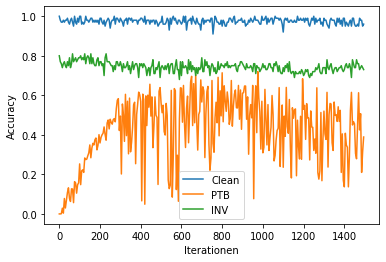

Not simultan


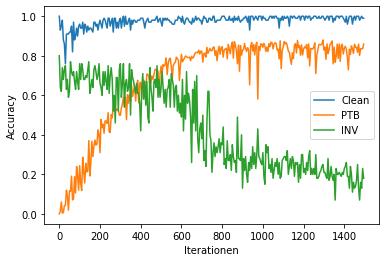

INV-PTB


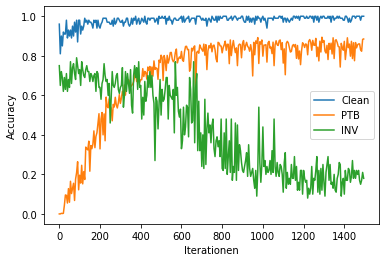

PTB-INV


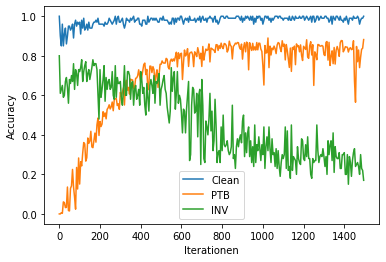

In [5]:
resolution=5


handler_simultan_trained = open('data/results/dritter_durchlauf/simultan.csv', 'r')
reader_simultan_trained = csv.DictReader(handler_simultan_trained)

handler_not_simultan_trained = open('data/results/dritter_durchlauf/not_simultan.csv', 'r')
reader_not_simultan_trained = csv.DictReader(handler_not_simultan_trained)

handler_inv_ptb_trained = open('data/results/dritter_durchlauf/inv_ptb.csv', 'r')
reader_inv_ptb_trained = csv.DictReader(handler_inv_ptb_trained)

handler_ptb_inv_trained = open('data/results/dritter_durchlauf/ptb_inv.csv', 'r')
reader_ptb_inv_trained = csv.DictReader(handler_ptb_inv_trained)



simultan_clean=[]
simultan_ptb=[]
simultan_inv=[]

not_simultan_clean=[]
not_simultan_ptb=[]
not_simultan_inv=[]

inv_ptb_clean=[]
inv_ptb_ptb=[]
inv_ptb_inv=[]

ptb_inv_clean=[]
ptb_inv_ptb=[]
ptb_inv_inv=[]


line_count = 0
for row in reader_simultan_trained: 
    if line_count % resolution==0:

        simultan_clean.append(float(row["clean_acc"]))        
        simultan_ptb.append(float(row["ptb_acc"]))
        simultan_inv.append(float(row["inv_acc"]))
    line_count+=1

line_count = 0
for row in reader_not_simultan_trained:
    if line_count % resolution==0:
        not_simultan_clean.append(float(row["clean_acc"]))
        not_simultan_ptb.append(float(row["ptb_acc"]))
        not_simultan_inv.append(float(row["inv_acc"]))
    line_count+=1

line_count = 0
for row in reader_inv_ptb_trained:
    if line_count % resolution==0:
        inv_ptb_clean.append(float(row["clean_acc"]))
        inv_ptb_ptb.append(float(row["ptb_acc"]))
        inv_ptb_inv.append(float(row["inv_acc"]))
    line_count+=1

line_count = 0
for row in reader_ptb_inv_trained:
    if line_count % resolution==0:
        ptb_inv_clean.append(float(row["clean_acc"]))
        ptb_inv_ptb.append(float(row["ptb_acc"]))
        ptb_inv_inv.append(float(row["inv_acc"]))
    line_count+=1


y=[]
i=500
j=0
while j<1500:
    y.append(j)
    j+=resolution

print("Simultan")  
plt.plot( y, simultan_clean, label = "Clean")
plt.plot( y, simultan_ptb,label = "PTB")
plt.plot( y, simultan_inv,label = "INV")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


print("Not simultan")
plt.plot( y, not_simultan_clean, label = "Clean")
plt.plot( y, not_simultan_ptb,label = "PTB")
plt.plot( y, not_simultan_inv,label = "INV")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


print("INV-PTB")
plt.plot( y, inv_ptb_clean, label = "Clean")
plt.plot( y, inv_ptb_ptb,label = "PTB")
plt.plot( y, inv_ptb_inv,label = "INV")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


print("PTB-INV")
plt.plot( y, ptb_inv_clean, label = "Clean")
plt.plot( y, ptb_inv_ptb,label = "PTB")
plt.plot( y, ptb_inv_inv,label = "INV")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vierter Durchlauf (Optimalen Wert für Anzahl an Invariance-Based Adversarial Examples finden)

# util

In [ ]:
# Checken ob human labels wohl passen...






new_labels=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_new_labels.npy")
human_labels=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_human_labels.npy")
inv_examples=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples.npy")

fig, axes = plt.subplots(10,10, figsize=(20,20))
for i in range(100):
    ax = axes[i//10,i%10]
    ax.imshow(inv_examples[i], cmap='gray')
    # ax.set_title('Label: {}'.format(inv_labels_to_train[i]))
    ax.set_title('Human: {}, New: {}'.format(human_labels[i], new_labels[i]))
plt.tight_layout()
plt.show()










